In [6]:
!pip install matplotlib

  Using cached matplotlib-3.4.3-cp39-cp39-manylinux1_x86_64.whl (10.3 MB)
  Using cached kiwisolver-1.3.2-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached Pillow-8.3.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [7]:
import h5py
import io
import logging
import math

import numpy as np
import random
import requests
import torch
import zarr

In [8]:
#@title utility  function to download / save data as zarr

def create_data(
    url, 
    name, 
    offset, 
    resolution,
    sections=None,
    squeeze=True):

  in_f = h5py.File(io.BytesIO(requests.get(url).content), 'r')

  raw = in_f['volumes/raw']
  labels = in_f['volumes/labels/neuron_ids']
  
  f = zarr.open(name, 'a')

  if sections is None:
    sections=range(raw.shape[0]-1)

  for i, r in enumerate(sections):

    print(f'Writing data for section {r}')

    raw_slice = raw[r:r+1,:,:]
    labels_slice = labels[r:r+1,:,:]

    if squeeze:
      raw_slice = np.squeeze(raw_slice)
      labels_slice = np.squeeze(labels_slice)

    f[f'raw/{i}'] = raw_slice
    f[f'labels/{i}'] = labels_slice

    f[f'raw/{i}'].attrs['offset'] = offset
    f[f'raw/{i}'].attrs['resolution'] = resolution

    f[f'labels/{i}'].attrs['offset'] = offset
    f[f'labels/{i}'].attrs['resolution'] = resolution

In [10]:
#lets use the some cremi challenge data as an example
create_data(
    'http://cremi.org/static/data/sample_A_20160501.hdf',
    'Data/training_data.zarr',
    offset=[0,0],
    resolution=[4,4])

Writing data for section 0
Writing data for section 1
Writing data for section 2
Writing data for section 3
Writing data for section 4
Writing data for section 5
Writing data for section 6
Writing data for section 7
Writing data for section 8
Writing data for section 9
Writing data for section 10
Writing data for section 11
Writing data for section 12
Writing data for section 13
Writing data for section 14
Writing data for section 15
Writing data for section 16
Writing data for section 17
Writing data for section 18
Writing data for section 19
Writing data for section 20
Writing data for section 21
Writing data for section 22
Writing data for section 23
Writing data for section 24
Writing data for section 25
Writing data for section 26
Writing data for section 27
Writing data for section 28
Writing data for section 29
Writing data for section 30
Writing data for section 31
Writing data for section 32
Writing data for section 33
Writing data for section 34
Writing data for section 35
Wr

In [ ]:
# conda install jupyter pytorch tensorboard h5py

from torch.utils.data import Dataset
import h5py


class ISBIDataset(Dataset):
    def __init__(self,filename):
        self.filename = filename
        self.samples = self.get_num_samples()

    def __len__(self):
        return self.samples

    def get_num_samples(self):
        with h5py.File(self.filename) as f:
            samples = f['raw'].shape[0]
        return samples

    def __getitem__(self,index):
        with h5py.File(self.filename) as f:
            x = f['raw'][index]
            y = f['affinities'][0,index]
        return torch.tensor(x).unsqueeze(0),torch.tensor(y).long()



In [15]:
import os
os.getcwd()

'/home/delsignores/defects_DLMBL/notebooks'

In [106]:
from torch.utils.data import Dataset
import h5py


class ISBIDataset(Dataset):
    def __init__(self,filename):
        self.filename = filename
        self.samples = self.get_num_samples()

    def __len__(self):
        return self.samples

    def get_num_samples(self):
        with zarr.open(self.filename, 'r') as f:
            samples = len(list(f['raw']))
        return samples

        
    def affinities(self, y, pad_size=1):
        # shift 1
        y0 = y[:-pad_size,:]
        y1 = y[pad_size:, :]
        aff1 = y0==y1
        aff1 = np.pad(aff1, ((1,0), (0,0)))
        
        #shift 2
        y11 = y[:, :-pad_size]
        y12 = y[:, pad_size:]
        aff2 = y11==y12
        aff2 = np.pad(aff2, ((0,0), (1,0)))
        
        return np.stack((aff1, aff2), axis=0)
            
    def __getitem__(self,index):
        with zarr.open(self.filename, 'r') as f:
            x = f[f'raw/{index}']
            y = f[f'labels/{index}']
        return (x, self.affinities(y))

    def affinity(self, y, pads=(1, 0)):
        padder=[[i, 0] for i in pads]
        slicer= [slice(0, -p) if p!=0 else slice(None) for p in pads]
        y1=np.pad(y, pad_width=padder)[slicer]
        aff = y==y1
        return aff
    
    def affinities(self, y, pads = ((1,0), (0,1), (1,1))):
        y_shape=y.shape
        dims = len(pads)
        affinities=np.zeros((dims, *y_shape))
        affinities[p,...] = self.affinity(y, pad)
        return affinities

In [75]:
fn='Data/training_data.zarr'

In [43]:
f = zarr.open(fn, 'r')

In [45]:
list(f.keys())

['labels', 'raw']

In [54]:
len(list(f['raw']))

124

In [67]:
f['labels/0'][:].shape

(1250, 1250)

In [107]:
arlosmagicdata=ISBIDataset('Data/training_data.zarr')

In [109]:
arlosmagicdata[0][1][0]

array([[False, False, False, ..., False, False, False],
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

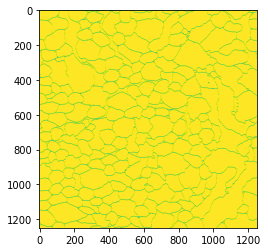

In [111]:
import matplotlib.pyplot as plt
plt.imshow(arlosmagicdata[0][1][0])

In [36]:
f.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,2
No. arrays,0
No. groups,2
Groups,"labels, raw"


In [37]:
list(f.keys())

['labels', 'raw']

In [26]:
! pip install zarr[jupyter]

     |████████████████████████████████| 1.3 MB 4.6 MB/s eta 0:00:01


In [27]:
f.tree()

Tree(nodes=(Node(disabled=True, name='/'),))

In [28]:
f.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,0
No. arrays,0
No. groups,0
